In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy.stats import sem
import matplotlib.cm as cm
from configs import engram_dir

# Helper functions

In [4]:
from sklearn.metrics import auc

In [5]:
def plot(
    df, figsize=(6.4*0.75, 4.8*0.75),
    fnames=None, figname=None, labels=None,
    smooth_plot=True, smooth_plot_n=2, colors=None,
    legend_title=None, ylim=None, plot_title=None, show_legend=True,
    plot_auc=False, ylabel='Avg Episode Score', xlim=None):
    
    fig, ax = plt.subplots(figsize=figsize)
    epsilons = np.sort(np.unique(df['epsilons']))
    if fnames is None:
        fnames = np.unique(df['model'])
    for fname_idx, fname in enumerate(fnames):
        means = []
        sems = []
        for eps in epsilons:
            df_subset = df[(df['model']==fname) & (df['epsilons']==eps)]
            vals = df_subset['valid_score']
            means.append(np.mean(vals))
            sems.append(sem(vals))
        means = np.array(means)
        sems = np.array(sems)
        if smooth_plot:
            means = smooth(epsilons, means, smooth_plot_n)
            sems = smooth(epsilons, sems, smooth_plot_n)
        line = np.array(means)
        shading_lower = means - sems
        shading_upper = means + sems
        x_axis = epsilons
        if colors is not None:
            color = colors[fname_idx]
        else:
            color = None
        if labels != None:
            label = fname_labels[fname_idx]
        else:
            label = fname
        ax.plot(x_axis, line, label=label, color=color, alpha=0.8)
        ax.fill_between(x_axis, shading_lower, shading_upper, alpha=0.2,color=color)
    plt.ylabel(ylabel)
    plt.xlabel('Policy $\epsilon$')
    if show_legend:
        plt.legend(title=legend_title, fontsize=12, title_fontsize=12)
    if ylim != None:
        plt.ylim(ylim[0], ylim[1])
    if xlim != None:
        plt.xlim(xlim[0], xlim[1])
    if plot_title != None:
        plt.title(plot_title)
    plt.tight_layout()
    if figname != None:
        plt.savefig(figname+'.png', dpi=300)
    plt.show()

In [6]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    vals[1:-1] = smoothed[1:-1]
    return vals

In [7]:
def get_df(base, z, epsilons, net_yaml, ep=600):
    data = {
        'valid_score': [], 'model': [],
        'epsilons': [], 'file': []}
    for epsilon in epsilons:
        eps_base = base
        if epsilon < 0.1:
            eps_base = 'frozenrandomtransfer_' + eps_base
            eps_base += f'_eps{epsilon:0.2f}'
        elif epsilon < 1.0:
            eps_base = 'frozenrandomtransfer_' + eps_base
            eps_base += f'_eps{epsilon:0.1f}'
        else:
            eps_base = 'frozentransfer_' + eps_base
        eps_base += '_shuffobs'
        task_dir = f'{eps_base}_{net_yaml}_dim{z}'
        task_dir = f'{engram_dir}pickles/{task_dir}/'
        if not os.path.exists(task_dir): continue
        for pickle_file in os.listdir(task_dir):
            if not pickle_file.endswith('.p'): continue
            pickle_file = f'{task_dir}{pickle_file}'
            with open(pickle_file, 'rb') as f:
                results = pickle.load(f)
            valid_score = results['valid_score']
            valid_score = smooth(results['episode'], valid_score, n=30)
            valid_steps = results['valid_steps_per_ep']
            model = results['model'][0].split(eps_base+'_')[-1]
            data['valid_score'].append(valid_score[ep])
            data['model'].append(model)
            data['epsilons'].append(epsilon)
            data['file'].append(pickle_file)
    df = pd.DataFrame(data)
    return df

# Early Learning

In [126]:
epsilons = [.05] + np.arange(0.1, 1.1, 0.1).tolist()

In [127]:
task_df = get_df('new_gridworld8x8', 17, epsilons, 'dm_large_q', ep=150)

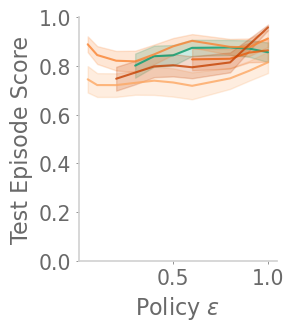

In [128]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, figsize=(6.4*0.5, 4.8*0.75),
    fnames=[
        'entro2',
        'g0_-2_entro-1',
        'g0.25_-2_entro0',
        'g0.5_-2_entro0',
        'g0.8_-4_entro0'],
    smooth_plot=True, smooth_plot_n=3,
    figname='gridworld6x6_taskA_early',
    colors=['C2']+[colors(c_steps[i]) for i in range(4)],
    show_legend=False,
    plot_title='', ylim=(0,1), ylabel='Test Episode Score'
    )

# Late Learning

In [129]:
epsilons = [.05] + np.arange(0.1, 1.1, 0.1).tolist()

In [130]:
task_df = get_df('new_gridworld8x8', 17, epsilons, 'dm_large_q', ep=600)

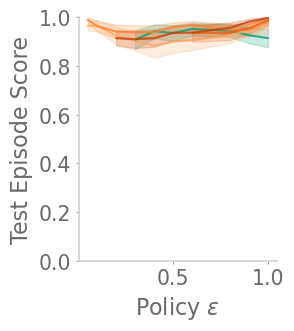

In [131]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, figsize=(6.4*0.5, 4.8*0.75),
    fnames=[
        'entro2',
        'g0_-2_entro-1',
        'g0.25_-2_entro0',
        'g0.5_-2_entro0',
        'g0.8_-4_entro0'],
    smooth_plot=True, smooth_plot_n=3,
    figname='gridworld6x6_taskA_early',
    colors=['C2']+[colors(c_steps[i]) for i in range(4)],
    show_legend=False,
    plot_title='', ylim=(0,1), ylabel='Test Episode Score'
    )